### Sebastián Rodríguez
### 20003076

# Proyecto 1 - Recurrent Neural Network

### Elección de dataset

Utilizamos un dataset de consumos energéticos por dos razones principales: 

- En donde laboro estamos involucrados con la eficiencia energética en nuestras líneas de producción y estamos buscando relacionar variables en equipo que nos pueden ayudar a identificar puntos de mejora y valores críticos en los consumos, dìa, mes, año.
- Un desarrollo para un modelo que nos indique la relación entre consumo de potencia global vs el voltaje consumido, intensidades y periodos de tiempo de consumo elevados son de gran utilidad para saber en donde estàn las mejoras. 

El dataset fue elegido en los links brindados del curso https://www.kaggle.com/search?q=data+power+consumption 

In [1]:
import sys 
import numpy as np
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


In [4]:
df = pd.read_csv('data_consumption.txt', sep=';', parse_dates={'dt' : ['Date', 'Time']}, 
                 infer_datetime_format=True, low_memory=False, na_values=['nan','?'], 
                 index_col='dt')

In [5]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [7]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
for j in range(1,7):
       print(df.iloc[:, j].unique())

[0.418 0.436 0.498 0.502 0.528 0.522 0.52  0.51  0.47  0.478 0.398 0.422
 0.282 0.152 0.156 0.    0.076 0.09  0.2   0.058 0.18  0.144 0.118 0.108
 0.202 0.192 0.186 0.116 0.136 0.148 0.16  0.158 0.1   0.082 0.05  0.052
 0.162 0.086 0.048 0.054 0.068 0.166 0.174 0.178 0.188 0.088 0.08  0.07
 0.084 0.074 0.106 0.092 0.064 0.046 0.138 0.134 0.132 0.12  0.13  0.154
 0.078 0.142 0.14  0.146 0.15  0.17  0.102 0.072 0.06  0.056 0.062 0.112
 0.066 0.172 0.168 0.194 0.184 0.096 0.164 0.182 0.094 0.098 0.176 0.19
 0.204 0.22  0.198 0.208 0.244 0.334 0.298 0.296 0.286 0.278 0.104 0.258
 0.238 0.256 0.214 0.23  0.21  0.24  0.124 0.122 0.27  0.302 0.272 0.25
 0.294 0.3   0.128 0.126 0.234 0.242 0.316 0.28  0.288 0.224 0.11  0.248
 0.254 0.222 0.246 0.216 0.212 0.114 0.206 0.228 0.226 0.196 0.218 0.368
 0.338 0.31  0.304 0.292 0.268 0.266 0.26  0.396 0.38  0.4   0.384 0.416
 0.404 0.382 0.232 0.314 0.312 0.262 0.252 0.236 0.348 0.342 0.34  0.35
 0.504 0.344 0.346 0.366 0.574 0.582 0.37  0.364 0.36  

In [9]:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [10]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [11]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


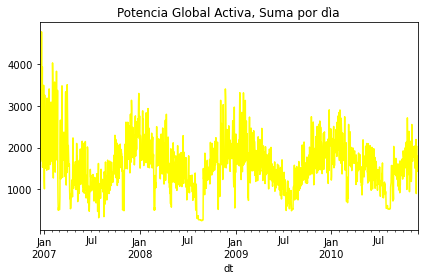

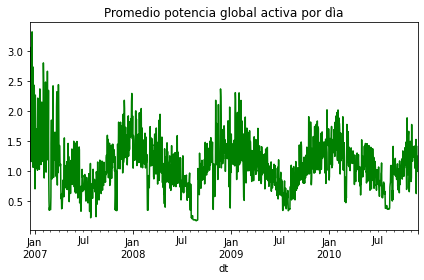

In [14]:

df.Global_active_power.resample('D').sum().plot(title='Potencia Global Activa, Suma por dìa', color ='yellow')  
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Promedio potencia global activa por dìa', color='green') 
plt.tight_layout()
plt.show()

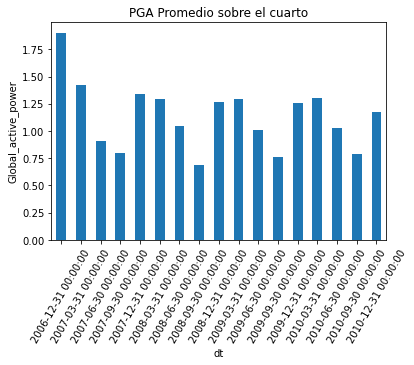

In [15]:
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('PGA Promedio sobre el cuarto')
plt.show()

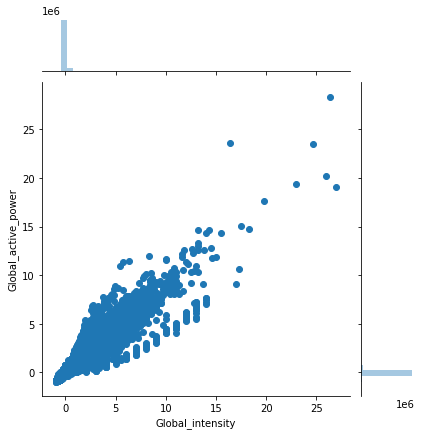

In [18]:
ret_data = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=ret_data)  

plt.show()

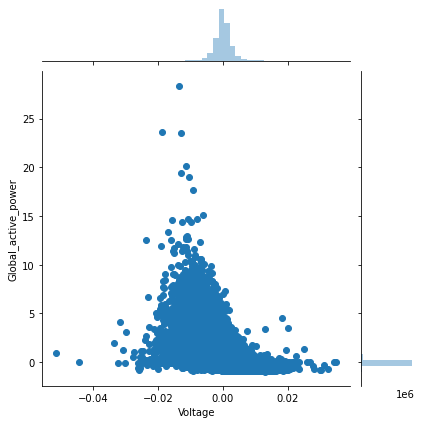

In [21]:
sns.jointplot(x='Voltage', y='Global_active_power', data=ret_data)  
plt.show()

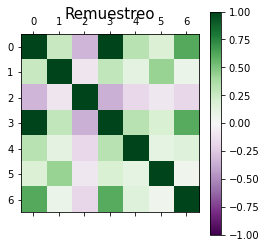

In [22]:
# Encontrando la correlación entre las diferentes columnas del dataset
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Remuestreo', size=15)
plt.colorbar()

In [23]:
def Supervision(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    argumentos = pd.concat(cols, axis=1)
    argumentos.columns = names
    if dropnan:
        argumentos.dropna(inplace=True)
    return argumentos

In [24]:
res_df = df.resample('h').mean() 
res_df.shape

(34589, 7)

In [26]:
res_df = df.resample('h').mean() 
res_df.shape

valores = res_df.values 


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(valores)

reframed = Supervision(scaled, 1, 1)

reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


In [28]:
valores = reframed.values
valores

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.01136636, 0.78241815,
        0.54504495],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.14465183, 0.78267595,
        0.50900588],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.03086863, 0.7741686 ,
        0.48854974],
       ...,
       [0.22519369, 0.06934998, 0.44873246, ..., 0.        , 0.        ,
        0.2385342 ],
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.00143575, 0.        ,
        0.16153105],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.022972  , 0.        ,
        0.12594772]])

In [42]:
tiempo = 365*24
train = valores[:tiempo, :]
test = valores[tiempo:, :]

Tr_X, train_y = train[:, :-1], train[:, -1]
TestF, PruebaF = test[:, :-1], test[:, -1]

Tr_X = Tr_X.reshape((Tr_X.shape[0], 1, Tr_X.shape[1]))
TestF = TestF.reshape((TestF.shape[0], 1, TestF.shape[1]))
print(Tr_X.shape, train_y.shape, TestF.shape, PruebaF.shape) 

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


Epoch 1/20
126/126 - 1s - loss: 0.0196 - val_loss: 0.0122
Epoch 2/20
126/126 - 0s - loss: 0.0127 - val_loss: 0.0107
Epoch 3/20
126/126 - 1s - loss: 0.0114 - val_loss: 0.0098
Epoch 4/20
126/126 - 0s - loss: 0.0109 - val_loss: 0.0094
Epoch 5/20
126/126 - 1s - loss: 0.0107 - val_loss: 0.0093
Epoch 6/20
126/126 - 0s - loss: 0.0106 - val_loss: 0.0093
Epoch 7/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 8/20
126/126 - 0s - loss: 0.0105 - val_loss: 0.0092
Epoch 9/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 10/20
126/126 - 0s - loss: 0.0104 - val_loss: 0.0093
Epoch 11/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 12/20
126/126 - 0s - loss: 0.0104 - val_loss: 0.0095
Epoch 13/20
126/126 - 0s - loss: 0.0104 - val_loss: 0.0093
Epoch 14/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 15/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 16/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 17/20
126/126 - 0s - loss: 0.0104 - val_loss: 0.0093
Epoch 

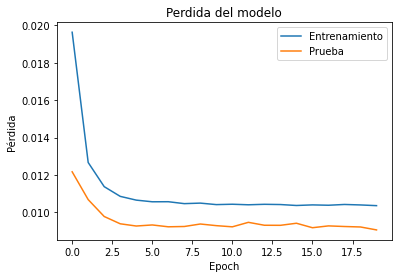

RMSE: 0.613


In [43]:
# Modelo CNN y una breve 
history = model.fit(Tr_X, train_y, epochs=20, batch_size=70, validation_data=(TestF, PruebaF), verbose=2, shuffle=False)
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper right')
plt.show()

yhat = model.predict(TestF)
TestF = TestF.reshape((TestF.shape[0], 7))

yhat_new = np.concatenate((yhat, TestF[:, -6:]), axis=1)
yhat_new = scaler.inverse_transform(yhat_new)
yhat_new = yhat_new[:,0]

PruebaF = PruebaF.reshape((len(PruebaF), 1))
Y_Final = np.concatenate((PruebaF, TestF[:, -6:]), axis=1)
Y_Final = scaler.inverse_transform(Y_Final)
Y_Final = Y_Final[:,0]

RMSE = np.sqrt(mean_squared_error(Y_Final, yhat_new))
print('RMSE: %.3f' % RMSE)



# Conclusiones

A pesar que la arquitectura tiene una buena forma para sondear datos, podemos observar que la RMSE no es tan adecuada como esperabamos para el set de datos de prueba. Podría haber hecho RMSProp con valores default para hacer un optimizador más eficiente. 

La otra forma hubiera sido utilizar un método de "annealing" para el learning rate. Tenìa un algoritmo con SGD, pero no es tan eficaz y baja bastante la RMSE total del modelo. 

